<a href="https://colab.research.google.com/github/laventura/pytorch_projects/blob/main/04_NLP_CharNN_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NLP from Scratch - Name classifier based on CharRNN

We will be building and training a basic character-level Recurrent Neural Network (RNN) to classify words. This tutorial, along with two other Natural Language Processing (NLP) “from scratch” tutorials NLP From Scratch: Generating Names with a Character-Level RNN and NLP From Scratch: Translation with a Sequence to Sequence Network and Attention, show how to preprocess data to model NLP. In particular these tutorials do not use many of the convenience functions of torchtext, so you can see how preprocessing to model NLP works at a low level.

A character-level RNN reads words as a series of characters - outputting a prediction and “hidden state” at each step, feeding its previous hidden state into each next step. We take the final prediction to be the output, i.e. which class the word belongs to.

Specifically, we’ll train on a few thousand surnames from 18 languages of origin, and predict which language a name is from based on the spelling:

```
$ python predict.py Hinton
(-0.47) Scottish
(-1.52) English
(-3.57) Irish

$ python predict.py Schmidhuber
(-0.19) German
(-2.48) Czech
(-2.68) Dutch
```


In [1]:
## Download dataset
import requests
import zipfile
import os


In [2]:
def download_and_unzip_data(url, target_dir='.'):
    # Create the target directory if it doesn't exist
    os.makedirs(target_dir, exist_ok=True)

    # Download the file
    print(f"Downloading URL: {url}")
    response = requests.get(url)
    if response.status_code == 200:
        # Get the filename from the URL
        filename = url.split('/')[-1]
        filepath = os.path.join(target_dir, filename)

        # Save the file
        with open(filepath, 'wb') as f:
            f.write(response.content)
        print(f"Downloaded {filename}")

        # Unzip the file
        with zipfile.ZipFile(filepath, 'r') as zip_ref:
            zip_ref.extractall(target_dir)
        print(f"Extracted contents to {target_dir}")

        # Remove the zip file
        os.remove(filepath)
        print(f"Removed {filename}")
    else:
        print(f"Failed to download the file. Status code: {response.status_code}")


In [3]:
dataset_url = "https://download.pytorch.org/tutorial/data.zip"
download_and_unzip_data(dataset_url)

Downloaded data.zip
Extracted contents to .
Removed data.zip


In [4]:
from io import open
import glob
import os

import unicodedata
import string

def findFiles(path): return glob.glob(path)


In [5]:
print(findFiles('data/names/*.txt'))

['data/names/Dutch.txt', 'data/names/Korean.txt', 'data/names/Scottish.txt', 'data/names/German.txt', 'data/names/Spanish.txt', 'data/names/Vietnamese.txt', 'data/names/Chinese.txt', 'data/names/Arabic.txt', 'data/names/Russian.txt', 'data/names/Polish.txt', 'data/names/Greek.txt', 'data/names/French.txt', 'data/names/Italian.txt', 'data/names/Portuguese.txt', 'data/names/Japanese.txt', 'data/names/Czech.txt', 'data/names/Irish.txt', 'data/names/English.txt']


In [15]:
## pre-processing
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)
print(n_letters)

57


In [16]:
# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

Slusarski


In [17]:
## Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

In [18]:
for filename in findFiles('data/names/*.txt'):
    category = os.path.basename(filename).replace('.txt', '')
    print(f"adding category: {category}")
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)
print(f"got {n_categories} categories")

adding category: Dutch
adding category: Korean
adding category: Scottish
adding category: German
adding category: Spanish
adding category: Vietnamese
adding category: Chinese
adding category: Arabic
adding category: Russian
adding category: Polish
adding category: Greek
adding category: French
adding category: Italian
adding category: Portuguese
adding category: Japanese
adding category: Czech
adding category: Irish
adding category: English
got 18 categories


In [19]:
# quick check
print(category_lines['Italian'][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


## Turn Names to Tensors

Now that we have all the names organized, we need to turn them into Tensors to make any use of them.

To represent a single letter, we use a “one-hot vector” of size `<1 x n_letters>`. A one-hot vector is filled with 0s except for a 1 at index of the current letter, e.g. `"b" = <0 1 0 0 0 ...>`.

To make a word we join a bunch of those into a 2D matrix `<line_length x 1 x n_letters>`.

That extra 1 dimension is because PyTorch assumes everything is in batches - we’re just using a batch size of 1 here.

In [20]:
import torch

# find letter index from all_letters, e.g. "a" = 0, "b" = 1, c = "2", ...

def letterToIndex(letter):
    return all_letters.find(letter)

# letter to 1-hot vector
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# turn a line into <line_length x 1 x n_letters>, or an array of one-hot vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for ln, letter in enumerate(line):
        tensor[ln][0][letterToIndex(letter)] = 1
    return tensor


In [21]:
# quick check
print(letterToTensor('K'))
print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


## Create a RNN

Before autograd, creating a recurrent neural network in Torch involved cloning the parameters of a layer over several timesteps. The layers held hidden state and gradients which are now entirely handled by the graph itself. This means you can implement a RNN in a very “pure” way, as regular feed-forward layers.

This RNN module implements a “vanilla RNN” an is just 3 linear layers which operate on an input and hidden state, with a `LogSoftmax` layer after the output.

In [28]:
import torch.nn as nn
import torch.nn.functional as F

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size, hidden_size)
        self.h2h = nn.Linear(hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        hidden = F.tanh(self.i2h(input) + self.h2h(hidden))
        output = self.h2o(hidden)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

In [29]:
# quick init
n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)
print(rnn)

RNN(
  (i2h): Linear(in_features=57, out_features=128, bias=True)
  (h2h): Linear(in_features=128, out_features=128, bias=True)
  (h2o): Linear(in_features=128, out_features=18, bias=True)
  (softmax): LogSoftmax(dim=1)
)


In [30]:
# quick check
input = letterToTensor('G')
hidden = torch.zeros(1, n_hidden)
output, next_hidden = rnn(input, hidden)
print(output)

tensor([[-2.9024, -2.8363, -2.9423, -2.8121, -2.7368, -2.8421, -2.9887, -2.9646,
         -2.9348, -2.9900, -2.6950, -2.9385, -2.9403, -2.8838, -2.9657, -2.8698,
         -2.9684, -2.8766]], grad_fn=<LogSoftmaxBackward0>)


In [33]:
# test with a name
input = lineToTensor('Ganesha')
hidden = torch.zeros(1, n_hidden)
output, next_hidden = rnn(input[0], hidden)
print(output)
print(output.size())  # size is (1, n_categories)

tensor([[-2.9024, -2.8363, -2.9423, -2.8121, -2.7368, -2.8421, -2.9887, -2.9646,
         -2.9348, -2.9900, -2.6950, -2.9385, -2.9403, -2.8838, -2.9657, -2.8698,
         -2.9684, -2.8766]], grad_fn=<LogSoftmaxBackward0>)
torch.Size([1, 18])


## Training

Before going into training we should make a few helper functions. The first is to interpret the output of the network, which we know to be a likelihood of each category. We can use `Tensor.topk` to get the index of the greatest value:

In [34]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i


In [35]:
# quick test
print(categoryFromOutput(output))

('Greek', 10)


In [37]:
import random

# quick way to get a training example
def randomChoice(l):
    return l[random.randint(0, len(l)-1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    cat, line, cat_tensor, line_tensor = randomTrainingExample()
    print(f"category {cat:<15} - line {line}")

category French          - line Bonheur
category Japanese        - line Chino
category Arabic          - line Atiyeh
category German          - line Hartmann
category Vietnamese      - line An
category Russian         - line Dzhanibekov
category English         - line Bridges
category Italian         - line Fiore
category French          - line Lebeau
category Portuguese      - line Silva


### Training the network

Now all it takes to train this network is show it a bunch of examples, have it make guesses, and tell it if it’s wrong.

For the loss function `nn.NLLLoss` is appropriate, since the last layer of the RNN is `nn.LogSoftmax`.

`criterion = nn.NLLLoss()`

Each loop of training will:

    Create input and target tensors

    Create a zeroed initial hidden state

    Read each letter in and

        Keep hidden state for next letter

    Compare final output to target

    Back-propagate

    Return the output and loss


In [38]:
learning_rate = 0.005

# criterion
criterion = nn.NLLLoss()

def train(category_tensor, line_tensor):
  hidden = rnn.initHidden()

  rnn.zero_grad()

  for i in range(line_tensor.size()[0]):
    output, hidden = rnn(line_tensor[i], hidden)


  loss = criterion(output, category_tensor)
  loss.backward()

  # add param gradients
  for p in rnn.parameters():
    p.data.add_(p.grad.data, alpha=-learning_rate)

  return output, loss.item()

In [39]:
import time
import math

n_iters = 100_000
print_every = 5000
plot_every = 1000

# keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
  now = time.time()
  s = now - since
  m = math.floor(s / 60)
  s -= m * 60
  return '%d %ds' % (m, s)


In [41]:
start = time.time()
for i in range(1, n_iters +1):
  category, line, category_tensor, line_tensor = randomTrainingExample()
  output, loss = train(category_tensor, line_tensor)
  current_loss += loss

  # print
  if i % print_every == 0:
    guess, guess_i = categoryFromOutput(output)
    correct = '✅' if guess == category else '❌ (%s)' % category
    print(f"{i:,} {timeSince(start):<10} - {loss:.4f} - {line:<12} / {guess:<12} {correct}")

  # add current loss
  if i % plot_every == 0:
    all_losses.append(current_loss / plot_every)
    current_loss = 0

5,000 0 8s       - 2.3619 - Voigt        / French       ❌ (German)
10,000 0 18s      - 2.4875 - Huffman      / English      ❌ (German)
15,000 0 28s      - 2.2378 - Gibson       / French       ❌ (Scottish)
20,000 0 37s      - 0.2167 - Haenraats    / Dutch        ✅
25,000 0 46s      - 0.1261 - Quirke       / Irish        ✅
30,000 0 56s      - 0.1719 - Wojda        / Polish       ✅
35,000 1 5s       - 0.1652 - Solomon      / French       ✅
40,000 1 14s      - 0.1663 - Rosario      / Portuguese   ✅
45,000 1 24s      - 1.0685 - Manus        / Irish        ✅
50,000 1 34s      - 0.2988 - Sarraf       / Arabic       ✅
55,000 1 43s      - 0.1086 - Rorris       / Greek        ✅
60,000 1 52s      - 1.2393 - Devin        / Russian      ❌ (Irish)
65,000 2 10s      - 0.0602 - Nunes        / Portuguese   ✅
70,000 2 20s      - 0.0241 - Shalhoub     / Arabic       ✅
75,000 2 30s      - 1.6508 - Otsuka       / Czech        ❌ (Japanese)
80,000 2 40s      - 0.0808 - Damhain      / Irish        ✅
85,000 2 

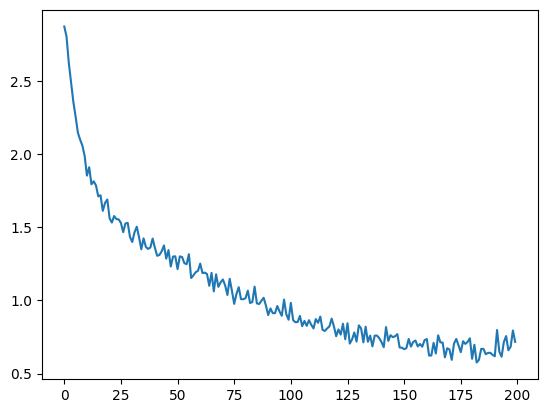

In [42]:
# plot results
import matplotlib.pyplot as plt

plt.figure()
plt.plot(all_losses)

### Evaluating results

To see how well the network performs on different categories, we will create a confusion matrix, indicating for every actual language (rows) which language the network guesses (columns). To calculate the confusion matrix a bunch of samples are run through the network with `evaluate()`, which is the same as `train()` minus the backprop.

In [43]:
# keep track of correct guesses in confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10_000

# evaluate - return an output given a line
def evaluate(line_tensor):
  hidden = rnn.initHidden()

  for i in range(line_tensor.size()[0]):
    output, hidden = rnn(line_tensor[i], hidden)

  return output

In [44]:
# go thru several examples and record which are correct
for i in range(n_confusion):
  cat, line, cat_tensor, line_tensor = randomTrainingExample()
  output = evaluate(line_tensor)
  guess, guess_i = categoryFromOutput(output)
  cat_i = all_categories.index(cat)
  confusion[cat_i][guess_i] += 1

# normalize by diving every row by its sum
for i in range(n_categories):
  confusion[i] = confusion[i] / confusion[i].sum()

<ipython-input-46-adb528c4612b>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)
<ipython-input-46-adb528c4612b>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


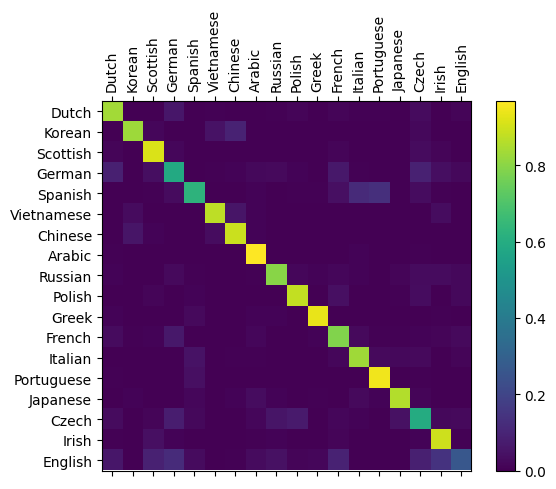

In [46]:
import matplotlib.ticker as ticker
# setup the plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# setup axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()
#

In [47]:
## run on user input
def predict(input_line, n_predictions=3):
  print(f"\n> {input_line}")

  with torch.no_grad():
    output = evaluate(lineToTensor(input_line))

    # get top N categories
    topv, topi = output.topk(n_predictions, 1, True)
    predictions = []

    for i in range(n_predictions):
      value = topv[0][i].item()
      cat_index = topi[0][i].item()
      print(f"{value:.4f} - {all_categories[cat_index]}")
      predictions.append([value, all_categories[cat_index]])

In [48]:
# predict some names
predict('Dostoevesky')
predict('Jackson')
predict('Satoshi')


> Dostoevesky
-0.5052 - Russian
-1.6424 - Czech
-1.6663 - Polish

> Jackson
-0.1740 - Scottish
-2.1531 - Russian
-3.4531 - English

> Satoshi
-0.3589 - Japanese
-1.4165 - Polish
-3.2808 - Arabic


Source: PyTorch tutorials https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html